# 3 - Imaging features normalization

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import os

## Introduction

During this step we will normalize the putamen and caudate DaTscan uptake values.

Since putamen and caudate uptake values fall in different range of values, and this could introduce bias during SNP-phenotype associations, we normalize the two measures.

Moreover, since DaTscan measures for both putamen and caudate are continous values, we normalized values with rank-based inverse normal transformation (r-INT). 

We choose r-INT for its lower susceptibility to outlier values.

In [2]:
patient_data_path = "../../data/patients_data/"
genotyping_path = "../../data/genotyping/"

## Exploring DaTSCAN data

On PPMI are available different DaTscan measures for several subjects involved in the study.

For healthy control subjects we have a measurement made during their baseline visit, while for PD patients are available DaTscan uptake values retrieved during their first visit and following tests.

In our study we consider only the values obtained at baseline.

In [3]:
ppmi_baseline_data = pd.read_csv(
    os.path.join(patient_data_path, "PPMI-baseline_data.csv")
)
datscan = ppmi_baseline_data.loc[
    :,["PATNO", "EVENT_ID", "CAUDATE_R", "CAUDATE_L", "PUTAMEN_R", "PUTAMEN_L"]
]
datscan = datscan.replace(".", np.nan)
datscan.head(n=10)

,PATNO,EVENT_ID,CAUDATE_R,CAUDATE_L,PUTAMEN_R,PUTAMEN_L
0,3000,BL,2.99,3.43,2.94,2.63
1,3001,BL,2,1.92,0.8,0.65
2,3002,BL,2.92,3.72,1.01,1.78
3,3003,BL,3.63,2.54,1.11,0.68
4,3004,BL,5.09,5.3,3.54,2.97
5,3006,BL,2.28,2.12,0.76,0.15
6,3007,BL,NaN,NaN,NaN,NaN
7,3008,BL,3.99,3.46,2.07,2.12
8,3009,BL,2.95,2.87,1.78,1.91
9,3010,BL,2.86,3.65,0.45,1.24


## Retrieving data related to our subjects

First, we need to retrieve the DaTscan measures obtained from the subjects we considered in our study during the first test they took.

We recall that we considered only HCs and PD subjects (SWEDD patients excluded) with European ancestry, to avoid possible bias due to population stratification, which can affect SNP-trait associations.

In [4]:
# loading CEU subjects IDs
ppmi_ceu_fam = pd.read_csv(
    os.path.join(genotyping_path, "PPMI_merge_ceu_noswedd.fam"),
    sep="\s+",
    header=None
)
ppmi_ceu_fam.head(n=10)

,0,1,2,3,4,5
0,3000,3000,0,0,2,-9
1,3001,3001,0,0,1,-9
2,3002,3002,0,0,2,-9
3,3004,3004,0,0,1,-9
4,3006,3006,0,0,2,-9
5,3008,3008,0,0,2,-9
6,3011,3011,0,0,1,-9
7,3012,3012,0,0,1,-9
8,3016,3016,0,0,1,-9
9,3018,3018,0,0,2,-9


In [5]:
# recover DaTscan values related to CEU subjects (without SWEDD)
datscan_ceu = datscan[datscan.PATNO.isin(ppmi_ceu_fam.iloc[:,1].tolist())]
datscan_ceu.head(n=10)

,PATNO,EVENT_ID,CAUDATE_R,CAUDATE_L,PUTAMEN_R,PUTAMEN_L
0,3000,BL,2.99,3.43,2.94,2.63
1,3001,BL,2,1.92,0.8,0.65
2,3002,BL,2.92,3.72,1.01,1.78
4,3004,BL,5.09,5.3,3.54,2.97
5,3006,BL,2.28,2.12,0.76,0.15
7,3008,BL,3.99,3.46,2.07,2.12
10,3011,BL,3.69,3.89,3.27,2.74
11,3012,BL,2.09,2.05,0.36,0.71
14,3016,BL,3.53,3.6,2.72,2.43
15,3018,BL,1.96,1.58,0.6,0.37


Remove whose subjects having missing DaTscan missing values.

In [6]:
print(datscan_ceu.shape)
datscan_ceu = datscan_ceu.dropna()
print(datscan_ceu.shape)

(434, 6)
(431, 6)


For three subjects (4082, 4083 and 4085) DaTscan values are not available. Therefore, we remove their data from our DataFrame.

In [7]:
datscan_ceu.reset_index(drop=True, inplace=True)
datscan_ceu.head(n=10)

,PATNO,EVENT_ID,CAUDATE_R,CAUDATE_L,PUTAMEN_R,PUTAMEN_L
0,3000,BL,2.99,3.43,2.94,2.63
1,3001,BL,2,1.92,0.8,0.65
2,3002,BL,2.92,3.72,1.01,1.78
3,3004,BL,5.09,5.3,3.54,2.97
4,3006,BL,2.28,2.12,0.76,0.15
5,3008,BL,3.99,3.46,2.07,2.12
6,3011,BL,3.69,3.89,3.27,2.74
7,3012,BL,2.09,2.05,0.36,0.71
8,3016,BL,3.53,3.6,2.72,2.43
9,3018,BL,1.96,1.58,0.6,0.37


We also remove those three subjects from our genotyping data, since we won't use them during the next steps of the analysis.

In [8]:
pd.DataFrame(
    zip(datscan_ceu.PATNO.tolist(), datscan_ceu.PATNO.tolist())
).to_csv(
    os.path.join(genotyping_path, "noDSnan_subjs.txt"),
    sep=" ",
    index=False,
    header=False
)

!plink --bfile {os.path.join(genotyping_path, "PPMI_merge_ceu_noswedd")} --keep {os.path.join(genotyping_path, "noDSnan_subjs.txt")} --make-bed --out {os.path.join(genotyping_path, "PPMI_merge_ceu_ds")}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_ceu_ds.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_ceu_noswedd
  --keep ../../data/genotyping/noDSnan_subjs.txt
  --make-bed
  --out ../../data/genotyping/PPMI_merge_ceu_ds

16384 MB RAM detected; reserving 8192 MB for main workspace.
164548 variants loaded from .bim file.
434 people (292 males, 142 females) loaded from .fam.
--keep: 431 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 431 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate in remaining samples is 0.997874.
164548 variants 

## Normalizing DaTSCAN values 

As previously highlighted, caudate and putamen uptake values fell in different range of values. To avoid potential errors during SNP-trait associations due to the different ranges of values, we need to normalize DaTscan values. 

To normalize DaTscan measures we apply rank-based inverse normal transformation, since this procedure is less susceptible to outliers.

Briefly, given a vector of continuous values $x$, r-INT normalizes it by accounting for the rank assigned to each value $x_{i}$ after sorting $x$ and computing for each $x_{i}$ the corresponding z-score.

For this procedure we use package RNOmni, which is available only on R enviroment.

Let's first plot DaTscan values distributions.

/Users/manuel/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/manuel/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


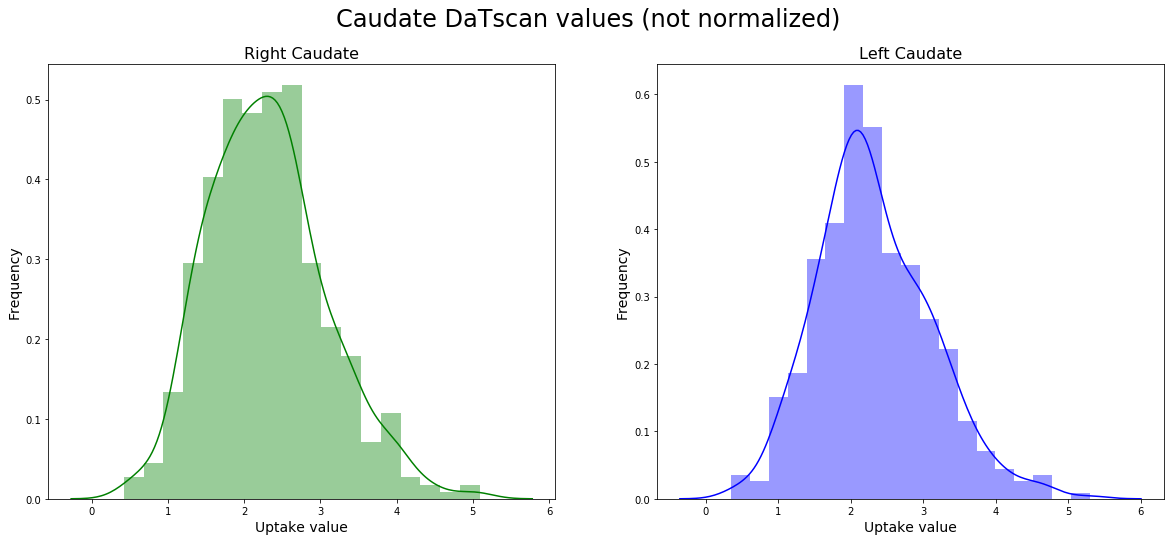

In [9]:
f, axes = plt.subplots(1,2, figsize=(20,8))
sns.distplot(datscan_ceu.CAUDATE_R, hist=True, ax=axes[0], color="green")
axes[0].set_xlabel("Uptake value", size=14)
axes[0].set_ylabel("Frequency", size=14)
axes[0].set_title("Right Caudate", size=16)
sns.distplot(datscan_ceu.CAUDATE_L, hist=True, ax=axes[1], color="blue")
axes[1].set_xlabel("Uptake value", size=14)
axes[1].set_ylabel("Frequency", size=14)
axes[1].set_title("Left Caudate", size=16)
plt.suptitle("Caudate DaTscan values (not normalized)", size=24)
plt.show()

/Users/manuel/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/manuel/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


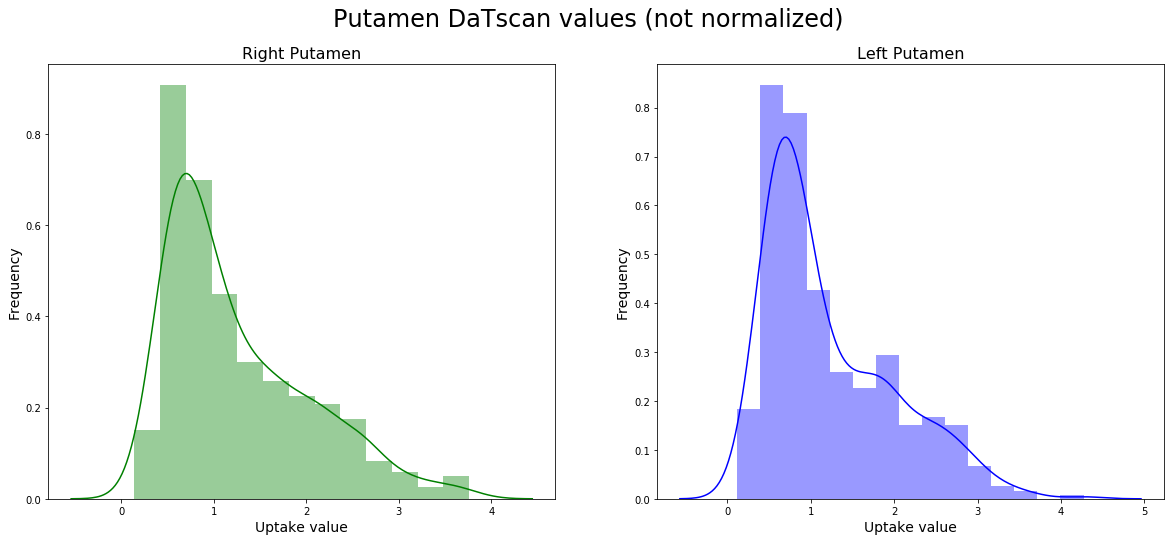

In [10]:
f, axes = plt.subplots(1,2, figsize=(20,8))
sns.distplot(datscan_ceu.PUTAMEN_R, hist=True, ax=axes[0], color="green")
axes[0].set_xlabel("Uptake value", size=14)
axes[0].set_ylabel("Frequency", size=14)
axes[0].set_title("Right Putamen", size=16)
sns.distplot(datscan_ceu.PUTAMEN_L, hist=True, ax=axes[1], color="blue")
axes[1].set_xlabel("Uptake value", size=14)
axes[1].set_ylabel("Frequency", size=14)
axes[1].set_title("Left Putamen", size=16)
plt.suptitle("Putamen DaTscan values (not normalized)", size=24)
plt.show()

Clearly, all four DaTscan features are not normally distributed. The presence of outlier values can lead to wrong SNP-trait associations during GWAS analysis. Therefore, we should normalize Caudate and Putamen DaTscan data. 

Let's store subsetted DaTscan data and then switch to R to carry out normalization step.

In [11]:
datscan_ceu.to_csv(
    os.path.join(patient_data_path, "DaTscan_CEU_filt.csv"),
    header=True,
    index=False
)

In [12]:
!Rscript datscanNorm.R

Carico il pacchetto richiesto: RNOmni
Warning message:
package ‘RNOmni’ was built under R version 3.6.2 


Now we can plot again DaTscan values distribution and see the changes introduced.

In [13]:
datscan_ceu_norm = pd.read_csv(
    os.path.join(patient_data_path, "DaTscan_CEU_norm.csv")
)
datscan_ceu_norm.head()

,PATNO,EVENT_ID,CAUDATE_R,CAUDATE_L,PUTAMEN_R,PUTAMEN_L
0,3000,BL,0.937686,1.365252,1.796193,1.459790
1,3001,BL,-0.316156,-0.499551,-0.310052,-0.643345
2,3002,BL,0.842657,1.643450,0.029066,0.697936
3,3004,BL,2.978297,2.978297,2.390802,1.891552
4,3006,BL,0.040699,-0.181173,-0.402989,-2.507063


/Users/manuel/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/manuel/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


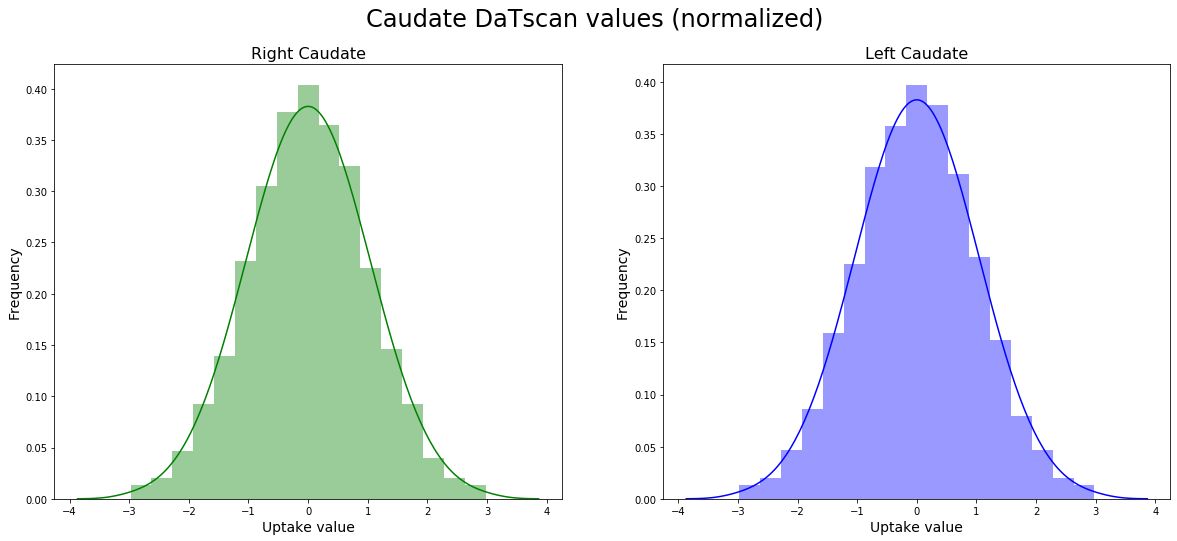

In [14]:
f, axes = plt.subplots(1,2, figsize=(20,8))
sns.distplot(datscan_ceu_norm.CAUDATE_R, hist=True, ax=axes[0], color="green")
axes[0].set_xlabel("Uptake value", size=14)
axes[0].set_ylabel("Frequency", size=14)
axes[0].set_title("Right Caudate", size=16)
sns.distplot(datscan_ceu_norm.CAUDATE_L, hist=True, ax=axes[1], color="blue")
axes[1].set_xlabel("Uptake value", size=14)
axes[1].set_ylabel("Frequency", size=14)
axes[1].set_title("Left Caudate", size=16)
plt.suptitle("Caudate DaTscan values (normalized)", size=24)
plt.show()

/Users/manuel/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/manuel/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


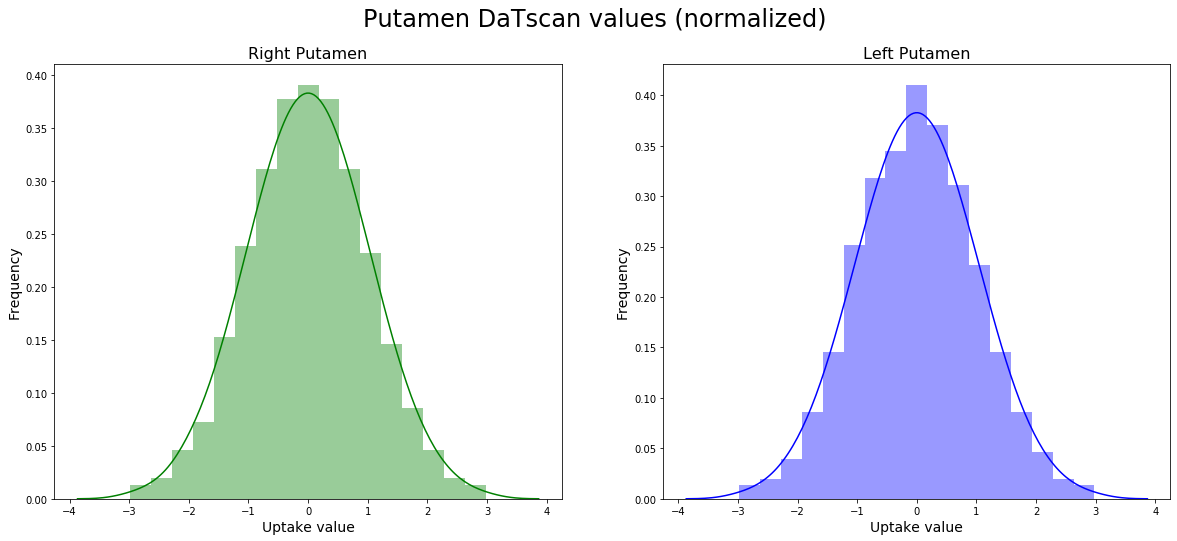

In [15]:
f, axes = plt.subplots(1,2, figsize=(20,8))
sns.distplot(datscan_ceu_norm.PUTAMEN_R, hist=True, ax=axes[0], color="green")
axes[0].set_xlabel("Uptake value", size=14)
axes[0].set_ylabel("Frequency", size=14)
axes[0].set_title("Right Putamen", size=16)
sns.distplot(datscan_ceu_norm.PUTAMEN_L, hist=True, ax=axes[1], color="blue")
axes[1].set_xlabel("Uptake value", size=14)
axes[1].set_ylabel("Frequency", size=14)
axes[1].set_title("Left Putamen", size=16)
plt.suptitle("Putamen DaTscan values (normalized)", size=24)
plt.show()

Let's now explore how the DaTSCAN values are distributed among the Healthy Controls and the PD patients.

In [16]:
datscan_ceu_norm = pd.read_csv(
    os.path.join(patient_data_path, "DaTscan_CEU_norm.csv")
)
ppmi_ceu_fam = pd.read_csv(
    os.path.join(genotyping_path, "PPMI_merge_ceu_ds.fam"),
    sep="\s+",
    header=None
)
ppmi_baseline_data_ceu = ppmi_baseline_data[ppmi_baseline_data.PATNO.isin(ppmi_ceu_fam.iloc[:,1].tolist())]
ppmi_baseline_data_ceu.reset_index(drop=True, inplace=True)
ppmi_baseline_data_ceu["CAUDATE_R_norm"] = datscan_ceu_norm.CAUDATE_R.tolist()
ppmi_baseline_data_ceu["CAUDATE_L_norm"] = datscan_ceu_norm.CAUDATE_L.tolist()
ppmi_baseline_data_ceu["PUTAMEN_R_norm"] = datscan_ceu_norm.PUTAMEN_R.tolist()
ppmi_baseline_data_ceu["PUTAMEN_L_norm"] = datscan_ceu_norm.PUTAMEN_L.tolist()
ppmi_baseline_data_ceu.head()

/Users/manuel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/manuel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/manuel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

,SITE,PATNO,APPRDX,EVENT_ID,age,age_cat,gen,EDUCYRS,educ,HISPLAT,...,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,SupraTentorialVolNotVent,SupraTentorialVolNotVentVox,CAUDATE_R_norm,CAUDATE_L_norm,PUTAMEN_R_norm,PUTAMEN_L_norm
0,10,3000,2,BL,69.1397,3,2,18,2,2,...,459739.038614,54579.0,628301.286475,9.996803e+05,9.777723e+05,973296.0,0.937686,1.365252,1.796193,1.459790
1,10,3001,1,BL,65.1425,2,1,16,2,2,...,538709.821583,65992.0,668025.901257,1.138365e+06,1.094811e+06,1092459.0,-0.316156,-0.499551,-0.310052,-0.643345
2,10,3002,1,BL,67.5781,3,2,16,2,2,...,404403.862641,53588.0,585538.400359,9.026203e+05,8.838913e+05,881444.0,0.842657,1.643450,0.029066,0.697936
3,10,3004,2,BL,59.4137,2,1,16,2,2,...,519025.135119,55264.0,640446.950904,1.074093e+06,1.056334e+06,1053446.0,2.978297,2.978297,2.390802,1.891552
4,10,3006,1,BL,57.5397,2,2,14,2,2,...,516101.202730,69343.0,691787.053845,1.120597e+06,1.091968e+06,1089715.0,0.040699,-0.181173,-0.402989,-2.507063


Interestingly, after normalization we can see a clear separation between the DaTSCAN uptake values of HC and PD patients for all the four imaging features.

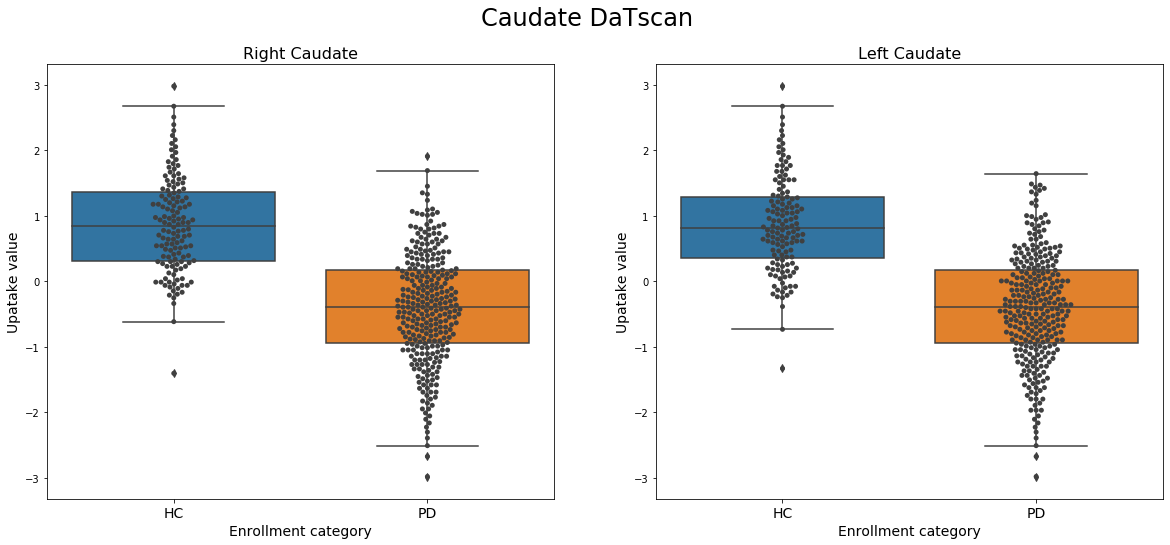

In [17]:
f, axes = plt.subplots(1,2, figsize=(20,8))
sns.boxplot(
    x="ENROLL_CAT",
    y="CAUDATE_R_norm",
    data=ppmi_baseline_data_ceu,
    ax=axes[0]
)
sns.swarmplot(
    x = "ENROLL_CAT",
    y = "CAUDATE_R_norm",
    data = ppmi_baseline_data_ceu,
    color = ".25",
    ax=axes[0]
)
axes[0].set_xlabel("Enrollment category", size=14)
axes[0].set_ylabel("Upatake value", size=14)
axes[0].set_title("Right Caudate", size=16)
axes[0].xaxis.set_tick_params(labelsize=14)
axes[0].set_xticks([0,1], ["HC", "PD"])
sns.boxplot(
    x = "ENROLL_CAT",
    y = "CAUDATE_L_norm",
    data = ppmi_baseline_data_ceu,
    ax=axes[1]
)
sns.swarmplot(
    x = "ENROLL_CAT",
    y = "CAUDATE_L_norm",
    data = ppmi_baseline_data_ceu,
    color = ".25",
    ax=axes[1]
)
axes[1].set_xlabel("Enrollment category", size=14)
axes[1].set_ylabel("Upatake value", size=14)
axes[1].set_title("Left Caudate", size=16)
axes[1].xaxis.set_tick_params(labelsize=14)
axes[1].set_xticks([0,1], ["HC", "PD"])
plt.suptitle("Caudate DaTscan", size=24)
plt.show()

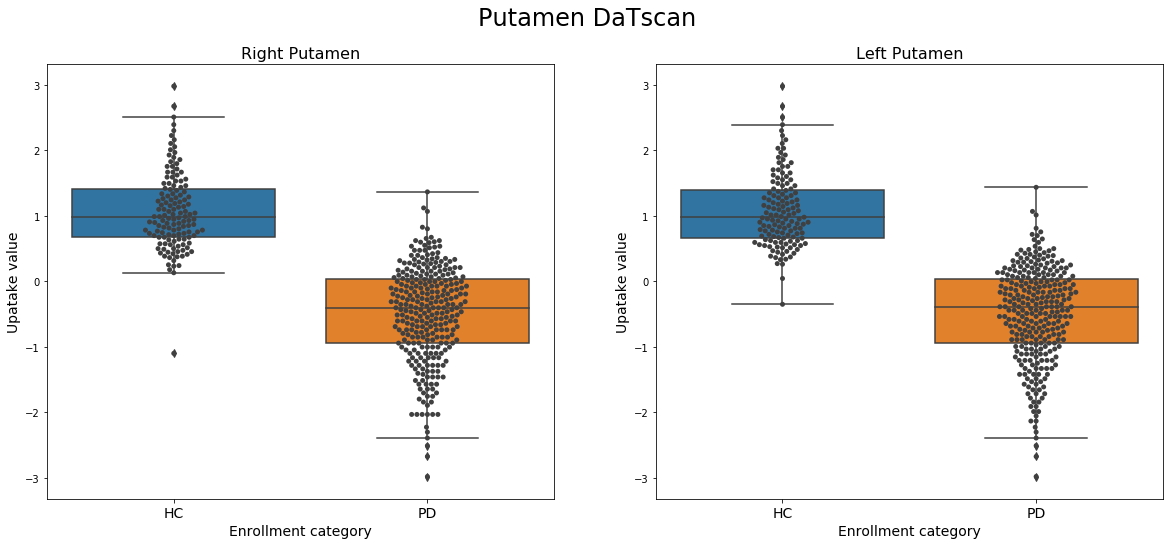

In [18]:
f, axes = plt.subplots(1,2, figsize=(20,8))
sns.boxplot(
    x="ENROLL_CAT",
    y="PUTAMEN_R_norm",
    data=ppmi_baseline_data_ceu,
    ax=axes[0]
)
sns.swarmplot(
    x = "ENROLL_CAT",
    y = "PUTAMEN_R_norm",
    data = ppmi_baseline_data_ceu,
    color = ".25",
    ax=axes[0]
)
axes[0].set_xlabel("Enrollment category", size=14)
axes[0].set_ylabel("Upatake value", size=14)
axes[0].set_title("Right Putamen", size=16)
axes[0].xaxis.set_tick_params(labelsize=14)
axes[0].set_xticks([0,1], ["HC", "PD"])
sns.boxplot(
    x = "ENROLL_CAT",
    y = "PUTAMEN_L_norm",
    data = ppmi_baseline_data_ceu,
    ax=axes[1]
)
sns.swarmplot(
    x = "ENROLL_CAT",
    y = "PUTAMEN_L_norm",
    data = ppmi_baseline_data_ceu,
    color = ".25",
    ax=axes[1]
)
axes[1].set_xlabel("Enrollment category", size=14)
axes[1].set_ylabel("Upatake value", size=14)
axes[1].set_title("Left Putamen", size=16)
axes[1].xaxis.set_tick_params(labelsize=14)
axes[1].set_xticks([0,1], ["HC", "PD"])
plt.suptitle("Putamen DaTscan", size=24)
plt.show()

Let's now store the new DataFrame to a CSV file.

In [19]:
ppmi_baseline_data_ceu.to_csv(
    os.path.join(patient_data_path, "PPMI-baseline_ceu.csv"),
    index=False
)